In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [2]:
df_application_train = pd.read_csv("../data/application_train.csv")

In [4]:
# クレジットカード残高データ
df_credit_card_balance = pd.read_csv("../data/credit_card_balance.csv")

# クレジットカード集約特徴量
df_credit_features = df_credit_card_balance.groupby("SK_ID_CURR").agg({
    "AMT_PAYMENT_CURRENT": ["sum", "std"],
    "AMT_BALANCE": ["std"],
    "AMT_CREDIT_LIMIT_ACTUAL": ["mean"],
    "CNT_DRAWINGS_ATM_CURRENT": ["sum"],
    "SK_DPD": ["sum"],
    "SK_DPD_DEF": ["sum"],
    "CNT_INSTALMENT_MATURE_CUM": ["sum"],
    "CNT_DRAWINGS_CURRENT": ["sum"],
    "AMT_TOTAL_RECEIVABLE": ["sum"],
    "AMT_INST_MIN_REGULARITY": ["mean"],
    "AMT_DRAWINGS_CURRENT": ["sum", "mean", "std"],
    "AMT_DRAWINGS_POS_CURRENT": ["sum", "mean", "std"]
})

# ------------------------
# bureauデータの読み込みと加工
# ------------------------
df_bureau = pd.read_csv("../data/bureau.csv")

# bad debtフラグ
df_bureau['BAD_DEBT_FLAG'] = (df_bureau['CREDIT_ACTIVE'] == 'Bad debt').astype(int)

# bureau集約特徴量
df_bureau_features = df_bureau.groupby("SK_ID_CURR").agg({
    "BAD_DEBT_FLAG": "max",  # 一度でもBad debtがあるか
    "DAYS_CREDIT": "max",
    "CREDIT_DAY_OVERDUE": ["max", "mean"],
    "AMT_CREDIT_MAX_OVERDUE": ["max", "sum"],
    "CNT_CREDIT_PROLONG": "max",
    "AMT_CREDIT_SUM": "mean",
    "AMT_CREDIT_SUM_LIMIT": "mean",
    "AMT_CREDIT_SUM_OVERDUE": ["max", "sum"],
    "DAYS_CREDIT_UPDATE": "min",
    "AMT_ANNUITY": "max"
})

# カラム名フラット化
df_bureau_features.columns = ['_'.join(col).upper() for col in df_bureau_features.columns]
df_bureau_features = df_bureau_features.reset_index()

# クレジットカード特徴量をフラット化（←これを入れ忘れてる）
df_credit_features.columns = ['_'.join(col).upper() if isinstance(col, tuple) else col for col in df_credit_features.columns]
df_credit_features = df_credit_features.reset_index()

# bureau特徴量もすでにフラット化済みと仮定
# マージ可能に
df_credit_features = df_credit_features.merge(df_bureau_features, on="SK_ID_CURR", how="outer")


In [5]:
# application_trainとcredit_featuresを結合
df_application_train = df_application_train.merge(df_credit_features, on="SK_ID_CURR", how="left")

# 特徴量リスト：credit_card_balance + bureau
features = [
    'CNT_CHILDREN',
    'AMT_INCOME_TOTAL',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'DAYS_BIRTH',
    'AMT_CREDIT',
    'DAYS_EMPLOYED',
    'DAYS_REGISTRATION',
    'AMT_ANNUITY',
    
    # credit_card_balance 由来
    'AMT_PAYMENT_CURRENT_SUM',
    'AMT_PAYMENT_CURRENT_STD',
    'AMT_BALANCE_STD',
    'AMT_CREDIT_LIMIT_ACTUAL_MEAN',
    'CNT_DRAWINGS_ATM_CURRENT_SUM',
    'SK_DPD_SUM',
    'SK_DPD_DEF_SUM',
    'CNT_INSTALMENT_MATURE_CUM_SUM',
    'CNT_DRAWINGS_CURRENT_SUM',
    'AMT_TOTAL_RECEIVABLE_SUM',
    'AMT_INST_MIN_REGULARITY_MEAN',
    'AMT_DRAWINGS_CURRENT_SUM',
    'AMT_DRAWINGS_CURRENT_MEAN',
    'AMT_DRAWINGS_CURRENT_STD',
    'AMT_DRAWINGS_POS_CURRENT_SUM',
    'AMT_DRAWINGS_POS_CURRENT_MEAN',
    'AMT_DRAWINGS_POS_CURRENT_STD',
    
    # bureau 由来
    'BAD_DEBT_FLAG_MAX',
    'DAYS_CREDIT_MAX',
    'CREDIT_DAY_OVERDUE_MAX',
    'CREDIT_DAY_OVERDUE_MEAN',
    'AMT_CREDIT_MAX_OVERDUE_MAX',
    'AMT_CREDIT_MAX_OVERDUE_SUM',
    'CNT_CREDIT_PROLONG_MAX',
    'AMT_CREDIT_SUM_MEAN',
    'AMT_CREDIT_SUM_LIMIT_MEAN',
    'AMT_CREDIT_SUM_OVERDUE_MAX',
    'AMT_CREDIT_SUM_OVERDUE_SUM',
    'DAYS_CREDIT_UPDATE_MIN',
    'AMT_ANNUITY_MAX'
]

# 説明変数・目的変数
X = df_application_train[features].copy()
# X.fillna(0, inplace=True)  ← 欠損処理は必要に応じて（LightGBMならNaN対応可能）

y = df_application_train['TARGET']

# StratifiedKFoldで交差検証
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
auc_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMClassifier(n_estimators=100, random_state=42, is_unbalance=True)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

# 結果出力
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)
print(f"\nMean AUC: {mean_auc:.4f}")
print(f"Std AUC:  {std_auc:.4f}")


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9093
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9089
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 40
[LightGBM] [In


Mean AUC: 0.7517


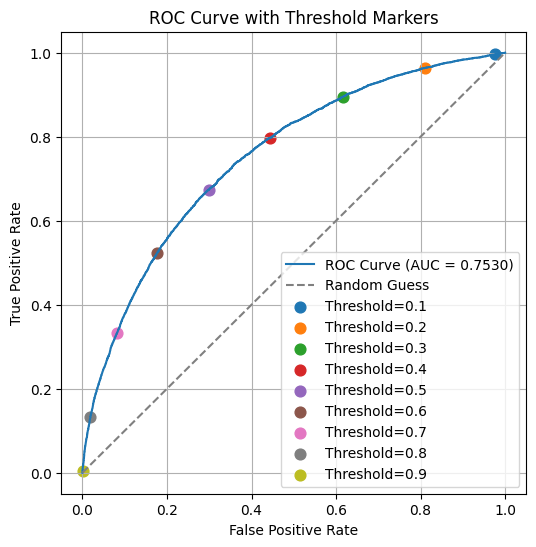

In [6]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

print(f"\nMean AUC: {sum(auc_scores) / len(auc_scores):.4f}")


# FPR, TPR, Thresholds の取得
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.4f})".format(roc_auc_score(y_val, y_pred)))
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")

# 特定のしきい値をマーク
for target_thresh in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ]:
    idx = (np.abs(thresholds - target_thresh)).argmin()
    plt.scatter(fpr[idx], tpr[idx], label=f"Threshold={target_thresh}", s=60)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Threshold Markers")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

thresholds_to_test = np.arange(0.1, 1.0, 0.1)

confusion_data = []

for thresh in thresholds_to_test:
    y_pred_label = (y_pred >= thresh).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_label).ravel()
    
    confusion_data.append({
        'Threshold': round(thresh, 2),
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        'Recall (TPR)': round(tp / (tp + fn + 1e-9), 3),
        'Precision': round(tp / (tp + fp + 1e-9), 3)
    })

df_confusion = pd.DataFrame(confusion_data)
display(df_confusion)


,Threshold,TP,FP,TN,FN,Recall (TPR),Precision
0,0.1,4945,55228,1309,20,0.996,0.082
1,0.2,4787,45874,10663,178,0.964,0.094
2,0.3,4447,34897,21640,518,0.896,0.113
3,0.4,3957,25077,31460,1008,0.797,0.136
4,0.5,3345,16900,39637,1620,0.674,0.165
5,0.6,2592,9951,46586,2373,0.522,0.207
6,0.7,1645,4593,51944,3320,0.331,0.264
7,0.8,653,1048,55489,4312,0.132,0.384
8,0.9,20,16,56521,4945,0.004,0.556


In [9]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # 特徴量の重要度（splitベース）
# importances = model.feature_importances_
# feature_names = X_train.columns

# # 可視化
# importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# plt.figure(figsize=(8,5))
# plt.barh(importance_df['Feature'], importance_df['Importance'])
# plt.gca().invert_yaxis()
# plt.title("LightGBM Feature Importances")
# plt.show()


In [12]:
import pandas as pd
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

shap_df = pd.DataFrame(shap_values, columns=X_val.columns, index=X_val.index)

display(shap_df.head().T)

shap_summary_df = pd.DataFrame({
    'Mean(|SHAP|)': shap_df.abs().mean(),
}).sort_values(by='Mean(|SHAP|)', ascending=False)

display(shap_summary_df)

/opt/anaconda3/envs/home-credit-default-risk/lib/python3.10/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


,1,4,11,13,15
CNT_CHILDREN,0.000040,0.000278,0.000780,-0.004743,-0.000528
AMT_INCOME_TOTAL,-0.159776,0.016437,0.050893,-0.032296,0.040077
EXT_SOURCE_1,0.094406,0.094460,-0.418278,0.122632,0.935119
EXT_SOURCE_2,-0.273636,0.459397,-0.025390,-0.142999,0.446820
EXT_SOURCE_3,-0.024176,0.078047,-0.405360,-0.678886,-0.378969
DAYS_BIRTH,0.120243,-0.138329,-0.015006,0.066073,-0.138369
AMT_CREDIT,-0.043946,0.036690,-0.258333,-0.078304,0.047303
DAYS_EMPLOYED,0.043750,-0.041063,-0.022761,-0.133403,0.101286
DAYS_REGISTRATION,-0.000239,0.017844,0.002022,0.031920,0.009275
AMT_ANNUITY,0.069868,0.022062,-0.189561,0.074851,0.040294


,Mean(|SHAP|)
EXT_SOURCE_2,0.365725
EXT_SOURCE_3,0.352380
EXT_SOURCE_1,0.212103
AMT_ANNUITY,0.123077
DAYS_EMPLOYED,0.107075
DAYS_BIRTH,0.101416
AMT_CREDIT,0.079869
DAYS_CREDIT_UPDATE_MIN,0.069155
CNT_DRAWINGS_ATM_CURRENT_SUM,0.047439
AMT_CREDIT_MAX_OVERDUE_MAX,0.047186


In [13]:
df_bureau = pd.read_csv("../data/bureau.csv")

# CREDIT_ACTIVEの値ごとの件数と割合を表示
credit_active_counts = df_bureau['CREDIT_ACTIVE'].value_counts(dropna=False)
credit_active_ratio = df_bureau['CREDIT_ACTIVE'].value_counts(normalize=True, dropna=False) * 100

# 表示
credit_active_summary = pd.DataFrame({
    'Count': credit_active_counts,
    'Percent (%)': credit_active_ratio.round(2)
})

print(credit_active_summary)


                 Count  Percent (%)
CREDIT_ACTIVE                      
Closed         1079273        62.88
Active          630607        36.74
Sold              6527         0.38
Bad debt            21         0.00
